In [1]:
## Import local library
import os
from datetime import datetime

## Import GeoPandas
import geopandas as gpd
import matplotlib.pyplot as plt

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, expr, broadcast, udf, lit, struct

## Import Apache Sedona
from sedona.spark import *

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1689028939035_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Create sedona session
A sedona session is created using existing spark session if present.

In [2]:
try:
    spark
    sedona = SedonaContext.create(spark)
except NameError:
    config = SedonaContext. \
        builder(). \
        appName('appName'). \
        getOrCreate()
    sedona = SedonaContext.create(config)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc = sedona.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

def delete_path(sc, path):
    fs = (sc._jvm.org
          .apache.hadoop
          .fs.FileSystem
          .get(sc._jsc.hadoopConfiguration())
          )
    fs.delete(sc._jvm.org.apache.hadoop.fs.Path(path), True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Use the prefix in all your EMR path

If you use EMR, EMR requires that all paths must be relative. You can use the variable below as the prefix for all paths.

In [4]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else ''

print(PATH_PREFIX)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load taxi pickup records to Sedona

In [5]:
taxidf = sedona.read.format('csv').option("header","true").option("delimiter", ",").load("s3a://wherobots-examples/data/nyc-taxi-data.csv")
taxidf.show()
taxidf = taxidf.selectExpr('ST_Point(CAST(Start_Lon AS Decimal(24,20)), CAST(Start_Lat AS Decimal(24,20))) AS pickup', 'Trip_Pickup_DateTime', 'Payment_Type', 'Fare_Amt')
taxidf = taxidf.filter(col("pickup").isNotNull())
taxidf.show()
taxidf.createOrReplaceTempView('taxiDf')
taxiRdd = Adapter.toSpatialRdd(taxidf, "pickup")
import shutil
shutil.rmtree(PATH_PREFIX + "taxi-pickup.geojson", ignore_errors=True)
delete_path(sc, PATH_PREFIX + "taxi-pickup.geojson")
taxiRdd.saveAsGeoJSON(PATH_PREFIX + "taxi-pickup.geojson")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------------+---------------------+---------------+-------------+----------+---------+---------+-----------------+----------+---------+------------+--------+---------+-------+-------+---------+---------+
|vendor_name|Trip_Pickup_DateTime|Trip_Dropoff_DateTime|Passenger_Count|Trip_Distance| Start_Lon|Start_Lat|Rate_Code|store_and_forward|   End_Lon|  End_Lat|Payment_Type|Fare_Amt|surcharge|mta_tax|Tip_Amt|Tolls_Amt|Total_Amt|
+-----------+--------------------+---------------------+---------------+-------------+----------+---------+---------+-----------------+----------+---------+------------+--------+---------+-------+-------+---------+---------+
|        VTS|         1/4/09 2:52|          1/4/09 3:02|              1|         2.63|-73.991957|40.721567|     null|             null|-73.993803|40.695922|        CASH|     8.9|      0.5|   null|      0|        0|      9.4|
|        VTS|         1/4/09 3:31|          1/4/09 3:38|              3|         4.55|-73.982102| 40

# Load Zones to Sedona

In [6]:
zoneDf = sedona.read.format('csv').option("delimiter", ",").load("s3a://wherobots-examples/data/TIGER2018_ZCTA5.csv")
zoneDf = zoneDf.selectExpr('ST_GeomFromWKT(_c0) as zone', '_c1 as zipcode')
zoneDf.show()
zoneDf.createOrReplaceTempView('zoneDf')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+
|                zone|zipcode|
+--------------------+-------+
|POLYGON ((-74.213...|  10312|
|POLYGON ((-74.164...|  10308|
|POLYGON ((-74.271...|  07077|
|POLYGON ((-74.169...|  10306|
|POLYGON ((-74.269...|  07064|
|POLYGON ((-74.254...|  07008|
|POLYGON ((-74.212...|  10314|
|POLYGON ((-74.101...|  10305|
|POLYGON ((-74.294...|  07001|
|POLYGON ((-74.013...|  11224|
|POLYGON ((-74.122...|  10304|
|POLYGON ((-74.014...|  11214|
|POLYGON ((-73.986...|  11223|
|POLYGON ((-74.305...|  07065|
|MULTIPOLYGON (((-...|  07036|
|MULTIPOLYGON (((-...|  10301|
|POLYGON ((-74.027...|  11228|
|POLYGON ((-74.041...|  11209|
|POLYGON ((-74.182...|  10311|
|POLYGON ((-74.026...|  11425|
+--------------------+-------+
only showing top 20 rows

# Visualize Sedona Dataframes on maps

In [7]:
zoneGpd = gpd.GeoDataFrame(zoneDf.toPandas(), geometry="zone")
taxiGpd = gpd.GeoDataFrame(taxidf.toPandas(), geometry="pickup")

zone = zoneGpd.plot(color='yellow', edgecolor='black', zorder=1)
zone.set_xlabel('Longitude (degrees)')
zone.set_ylabel('Latitude (degrees)')

# Local view
zone.set_xlim(-74.1, -73.8)
zone.set_ylim(40.65, 40.9)

taxi = taxiGpd.plot(ax=zone, alpha=0.01, color='red', zorder=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

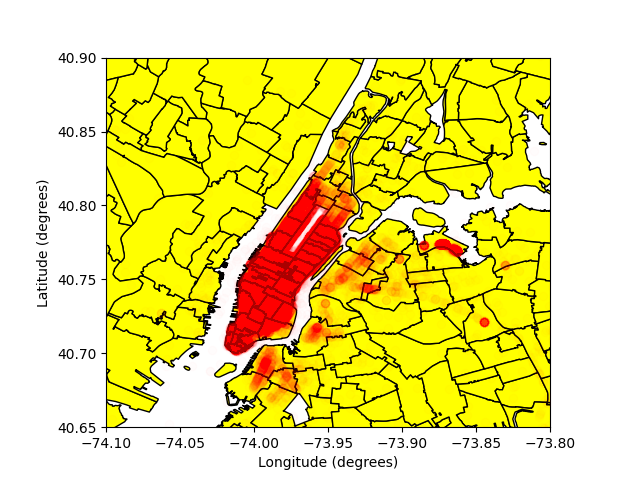

In [8]:
%matplot plt

# Geofence query to only keep records in Manhattan

In [9]:
taxidf_mhtn = taxidf.where('ST_Contains(ST_PolygonFromEnvelope(-74.01,40.73,-73.93,40.79), pickup)')

taxiGpdMhtn = gpd.GeoDataFrame(taxidf_mhtn.toPandas(), geometry="pickup")
zoneGpd = gpd.GeoDataFrame(zoneDf.toPandas(), geometry="zone")
zone = zoneGpd.plot(color='yellow', edgecolor='black', zorder=1)
zone.set_xlabel('Longitude (degrees)')
zone.set_ylabel('Latitude (degrees)')

# Local view
zone.set_xlim(-74.1, -73.8)
zone.set_ylim(40.65, 40.9)
taxi = taxiGpdMhtn.plot(ax=zone, alpha=0.01, color='red', zorder=3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

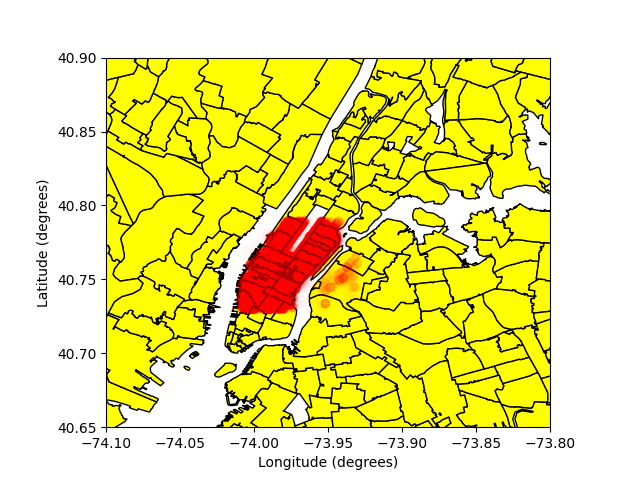

In [10]:
%matplot plt